# Song lyrics - Part 1: Overview

This is the first of several notebooks examining the song lyrics dataset. This notebook explores some basic properties of the dataset, while also tidying up the data for analysis in the following notebooks.

## Imports

In [1]:
import re
import sys
from ast import literal_eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import ScalarFormatter
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2)
from nltk.corpus import words as nltk_words
from scipy.stats import linregress

from adjustText import adjust_text


sys.path.append('../scripts/')

from nlp import tokenize

## Data

The dataset used here is the table of artist/album/song info and lyrics for every song in the core dataset.

In [50]:
df = pd.read_csv('../songs.csv', low_memory=False)
df = df[~df.song_darklyrics.isnull()]
df = df[df.song_darklyrics.str.strip().apply(len) > 0]
print(df.columns)
print(df.shape)

Index(['band_name', 'band_id', 'band_url', 'band_country_of_origin',
       'band_location', 'band_status', 'band_formed_in', 'band_genre',
       'band_lyrical_themes', 'band_last_label', 'band_years_active',
       'album_name', 'album_type', 'album_year', 'album_review_num',
       'album_review_avg', 'album_url', 'album_reviews_url', 'song_name',
       'song_length', 'song_url', 'song_darklyrics', 'song_darklyrics_url',
       'band_current_label'],
      dtype='object')
(119215, 24)


#### Cleanup song lyrics

There were some issues when parsing lyrics. They are handled here since it isn't quite worth it to rescrape all of darklyrics again with a new scraper.

In [3]:
print('Number of songs', len(df))

Number of songs 119215


In [4]:
# Remove songs that are mostly non-English

min_english = 0.6  # A little higher than 50% to include songs with translations, whose lyrics typically include original and translated text

rows = []
song_words = []
for i, row in df.iterrows():
    text = row.song_darklyrics.strip()
    words = tokenize(text)
    english_words = tokenize(text, english_only=True)
    is_english = len(english_words) > min_english * len(words)
    if is_english:
        rows.append(row)
        song_words.append(english_words)
print('Non-English songs removed: ', len(df) - len(rows))
df = pd.DataFrame(rows, columns=df.columns)
df['song_words'] = song_words

Non-English songs removed:  9475


In [5]:
# Remove songs that were copyright claimed

copyrighted = df.song_darklyrics.str.contains('lyrics were removed due to copyright holder\'s request')
print('Songs with lyrics removed: ', len(df[copyrighted]))
df = df[~copyrighted]

Songs with lyrics removed:  107


#### Reduced dataset

For lyrical analyses the data is reduced to just a column of lyrics (which will become the feature vector upon some transformation to a quantitative representation) for each song and columns for the most popular genres (the target/label vectors). These are the genres that appear at least once in isolation, i.e. not accompanied by any other genre, and that appear in some minimum percentage of songs. For example, the “black” metal label can appear on bands with or without other genres, but a label like “atmospheric” never appears on its own despite being fairly popular, usually because it is more of an adjective to denote subgenres like atmospheric black metal; thus “black” is included in the reduced label space but “atmospheric” is not. This reduces the genres to a more manageable set: five genres if the minimum occurrence requirement is set to 10%, and thirteen if set to 1%.

A five-genre set would be easier to handle but leaves quite a few holes in the label space, because doom metal, metalcore, folk metal, and many other fairly popular genres are being omitted that may not be covered by any of the five labels. The larger label set covers just about all the most important genres, but because eight of them occur in fewer than 10% of all songs, they will force greater class imbalance which will adversely affect attempts at applying binary classification models later on. For the sake of comparison, both reduced datasets are saved here, but the rest of this exploratory analysis only looks at the 1% dataset, while the 10% dataset is reserved for modeling. Each dataset is saved in its raw form and in a truncated (ML-ready) form containing only the lyrics and genre columns.

In [6]:
def process_genre(genre):
    # Find words (including hyphenated words) not in parentheses
    out = re.findall('[\w\-]+(?![^(]*\))', genre.lower())
    out = [s for s in out if s != 'metal']
    return out


song_genres = df.band_genre.apply(process_genre)
genres = sorted(set(song_genres.sum()))
genre_cols = {f'genre_{genre}': song_genres.apply(lambda x: int(genre in x)) for genre in genres}
df = df.join(pd.DataFrame(genre_cols))

In [7]:
def get_top_genres(data, min_pct):
    isolated = (data.sum(axis=1) == 1)
    isolated_cols = sorted(set(data[isolated].idxmax(axis=1)))
    top_cols = [col for col in isolated_cols if data[col][isolated].mean() >= min_pct]
    top_genres = [re.sub(r"^genre\_", "", col) for col in top_cols]
    return top_genres

In [8]:
top_genres_1pct = get_top_genres(df[genre_cols.keys()], 0.01)
print(top_genres_1pct)
df_r = df.copy()
drop_cols = [col for col in df.columns if ('genre_' in col) and (re.sub(r"^genre\_", "", col) not in top_genres_1pct)]
df_r.drop(drop_cols, axis=1, inplace=True)

# Only lyrics and genre are relevant for ML later
df_r_ml = pd.DataFrame(index=range(df.shape[0]), columns=['lyrics'] + top_genres_1pct)
df_r_ml['lyrics'] = df['song_darklyrics'].reset_index(drop=True)
df_r_ml[top_genres_1pct] = df[[f"genre_{genre}" for genre in top_genres_1pct]].reset_index(drop=True)

['black', 'death', 'deathcore', 'doom', 'folk', 'gothic', 'grindcore', 'heavy', 'metalcore', 'power', 'progressive', 'symphonic', 'thrash']


In [9]:
top_genres_10pct = get_top_genres(df[genre_cols.keys()], 0.1)
print(top_genres_10pct)
df_rr = df.copy()
drop_cols = [col for col in df.columns if ('genre_' in col) and (re.sub(r"^genre\_", "", col) not in top_genres_10pct)]
df_rr.drop(drop_cols, axis=1, inplace=True)

# Only lyrics and genre are relevant for ML later
df_rr_ml = pd.DataFrame(index=range(df.shape[0]), columns=['lyrics'] + top_genres_10pct)
df_rr_ml['lyrics'] = df['song_darklyrics'].reset_index(drop=True)
df_rr_ml[top_genres_10pct] = df[[f"genre_{genre}" for genre in top_genres_10pct]].reset_index(drop=True)

['black', 'death', 'heavy', 'power', 'thrash']


In [10]:
df_r.shape, df_rr.shape

((109633, 38), (109633, 30))

In [11]:
df_r.to_csv('../songs-1pct.csv')
df_rr.to_csv('../songs-10pct.csv')

## Basic lyrical properties

This section compares looks at word counts and unique word counts, in absolute counts as well as counts per minute, between different songs, albums, bands, and genres. [Part 3](./lyrics2.ipynb) dives much deeper into evaluating lyrical complexity using various lexical diversity measures from the literature.

Song lyrics are tokenized using a custom `tokenize()` function in `nlp.py`.

In [2]:
df_r = pd.read_csv('../songs-1pct.csv')
df_r['song_words'] = df_r['song_words'].str.split()
top_genres_1pct = [c for c in df_r.columns if 'genre_' in c]

df_rr = pd.read_csv('../songs-10pct.csv')
df_rr['song_words'] = df_rr['song_words'].str.split()
top_genres_10pct = [c for c in df_rr.columns if 'genre_' in c]

## Word counts by song

In [3]:
def to_seconds(data):
    """Convert a time string (MM:ss or HH:MM:ss) to seconds
    """
    out = pd.Series(index=data.index, dtype=int)
    for i, x in data.items():
        if isinstance(x, str):
            xs = x.split(':')
            if len(xs) < 3:
                xs = [0] + xs
            seconds = int(xs[0]) * 3600 + int(xs[1]) * 60 + int(xs[2])
        else:
            seconds = 0
        out[i] = seconds
    return out


def get_words_per_second(data):
    out = pd.DataFrame(index=data.index, dtype=float)
    out['words_per_second'] = (data['word_count'] / data['seconds']).round(2)
    out['words_per_second'][out['words_per_second'] == np.inf] = 0
    out['unique_words_per_second'] = (data['unique_word_count'] / data['seconds']).round(2)
    out['unique_words_per_second'][out['unique_words_per_second'] == np.inf] = 0
    return pd.concat([data, out], axis=1)

In [4]:
df_r_songs = df_r[['band_name', 'album_name', 'song_name', 'band_genre', 'song_words', 'song_length']].copy()
df_r_songs = df_r_songs.rename(columns={'band_name': 'band', 'album_name': 'album', 'song_name': 'song', 'band_genre': 'genre', 'song_words': 'words'})
df_r_songs['seconds'] = to_seconds(df_r_songs['song_length'])
df_r_songs = df_r_songs.drop('song_length', axis=1)
df_r_songs['word_count'] = df_r_songs['words'].apply(len)
df_r_songs['unique_word_count'] = df_r_songs['words'].apply(lambda x: len(set(x)))
df_r_songs = get_words_per_second(df_r_songs)

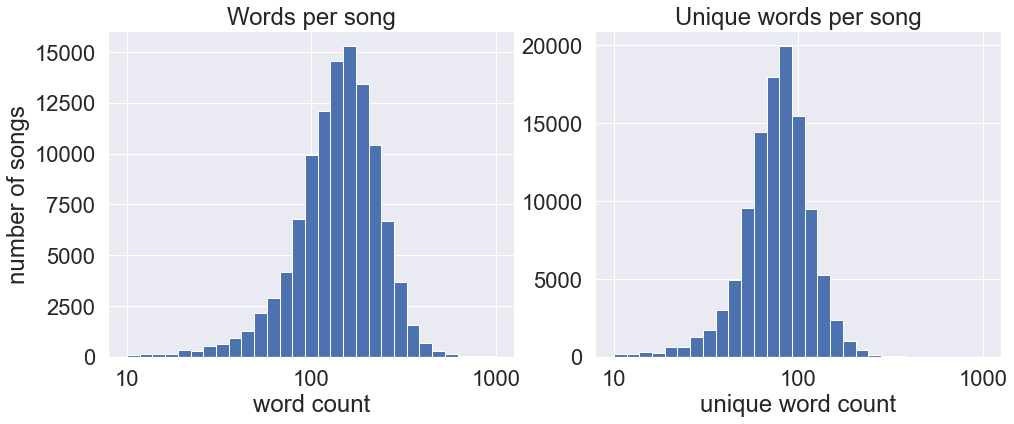

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

df_r_songs['word_count'].hist(bins=np.logspace(1, 3, 30), ax=ax1)
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(ScalarFormatter())
ax1.set_xlabel("word count")
ax1.set_ylabel("number of songs")
ax1.set_title("Words per song")

df_r_songs['unique_word_count'].hist(bins=np.logspace(1, 3, 30), ax=ax2)
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.set_xlabel("unique word count")
ax2.set_title("Unique words per song")

plt.show()

#### Songs with highest word counts

The honor of highest word count in a single song goes to the [Bal-Sagoth's "The Obsidian Crown Unbound"](https://youtu.be/xizMG4nI2dk) at over two thousand words. However, most of those words are not sung in the actual song: Bal-Sagoth lyrics typically include the massive collection of narrative text that accompanies their songs. Although the lyrics they sing are still plentiful, there are nowhere near two thousand words spoken in the six-minute symphonic black metal track.

This makes the forty-minute prog metal epic [Crimson by Edge of Sanity](https://youtu.be/St6lJaiHYIc) a better contender for most verbose song. Still, such a claim might be challenged by the fact that the digital edition of the album, which a listener would find on Spotify for instance, divides the single-track album into eight parts. That said, DarkLyrics keeps the original one-track format.

At third place is another multi-part song, [Mirror of Souls](https://youtu.be/y6n1kMsLbc8) by the Christian progressive/power metal group Theocracy. This is less contentious since the official track listing considers this a single track.

In [6]:
song_cols_show = [c for c in df_r_songs.columns if c != 'words']

In [7]:
df_r_songs.sort_values('word_count', ascending=False).reset_index().shift(1).loc[1:10, song_cols_show].convert_dtypes()

,band,album,song,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Bal-Sagoth,The Chthonic Chronicles,The Obsidian Crown Unbound,Symphonic/Epic Black Metal,358,2259,897,6.31,2.51
2,Edge of Sanity,Crimson,Crimson,Progressive Death Metal,2400,1948,658,0.81,0.27
3,Theocracy,Mirror of Souls,Mirror of Souls,Epic Progressive Power Metal,1346,1556,457,1.16,0.34
4,Cephalectomy,Sign of Chaos,Unto the Darkly Shining Abyss,Experimental Death Metal/Grindcore,383,1338,391,3.49,1.02
5,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,To Dethrone the Witch-Queen of Mytos K'unn (Th...,Symphonic/Epic Black Metal,405,1306,548,3.22,1.35
6,Seventh Wonder,The Great Escape,The Great Escape,Progressive Metal,1814,1306,504,0.72,0.28
7,Bal-Sagoth,The Chthonic Chronicles,Unfettering the Hoary Sentinels of Karnak,Symphonic/Epic Black Metal,262,1237,560,4.72,2.14
8,Bal-Sagoth,Battle Magic,Blood Slakes the Sand at the Circus Maximus,Symphonic/Epic Black Metal,533,1186,530,2.23,0.99
9,Redemption,Redemption,Something Wicked This Way Comes,Progressive Metal,1466,1114,439,0.76,0.3
10,Cephalectomy,Sign of Chaos,Gates to the Spheres of Astral Frost,Experimental Death Metal/Grindcore,233,1065,339,4.57,1.45


#### Songs with highest unique word counts

In [8]:
df_r_songs.sort_values('unique_word_count', ascending=False).reset_index().shift(1).loc[1:10, song_cols_show].convert_dtypes()

,band,album,song,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Bal-Sagoth,The Chthonic Chronicles,The Obsidian Crown Unbound,Symphonic/Epic Black Metal,358,2259,897,6.31,2.51
2,Edge of Sanity,Crimson,Crimson,Progressive Death Metal,2400,1948,658,0.81,0.27
3,Bal-Sagoth,The Chthonic Chronicles,Unfettering the Hoary Sentinels of Karnak,Symphonic/Epic Black Metal,262,1237,560,4.72,2.14
4,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,To Dethrone the Witch-Queen of Mytos K'unn (Th...,Symphonic/Epic Black Metal,405,1306,548,3.22,1.35
5,Bal-Sagoth,Battle Magic,Blood Slakes the Sand at the Circus Maximus,Symphonic/Epic Black Metal,533,1186,530,2.23,0.99
6,Seventh Wonder,The Great Escape,The Great Escape,Progressive Metal,1814,1306,504,0.72,0.28
7,Theocracy,Mirror of Souls,Mirror of Souls,Epic Progressive Power Metal,1346,1556,457,1.16,0.34
8,Redemption,Redemption,Something Wicked This Way Comes,Progressive Metal,1466,1114,439,0.76,0.3
9,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,The Splendour of a Thousand Swords Gleaming Be...,Symphonic/Epic Black Metal,363,977,429,2.69,1.18
10,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,Starfire Burning upon the Ice-Veiled Throne of...,Symphonic/Epic Black Metal,443,1018,427,2.3,0.96


#### Songs with highest word density

Unfortunately songs by number of words per seconds or unique words per second yields mostly songs with commentary/not-sung lyrics...

In [9]:
df_r_songs.sort_values('words_per_second', ascending=False).reset_index().shift(1).loc[1:10, song_cols_show].convert_dtypes()

,band,album,song,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Nanowar of Steel,Into Gay Pride Ride,Karkagnor's Song - In the Forest,Heavy/Power Metal/Hard Rock,10,286,159,28.6,15.9
2,Cripple Bastards,Your Lies in Check,Rending Aphthous Fevers,Noisecore (early); Grindcore (later),7,81,51,11.57,7.29
3,Cripple Bastards,Desperately Insensitive,Bomb ABC No Rio,Noisecore (early); Grindcore (later),63,482,286,7.65,4.54
4,Hortus Animae,Waltzing Mephisto,A Lifetime Obscurity,Progressive Black Metal,57,418,193,7.33,3.39
5,Gore,Consumed by Slow Decay,Inquisitive Corporeal Recremation,Goregrind,16,103,66,6.44,4.12
6,Bal-Sagoth,The Chthonic Chronicles,The Obsidian Crown Unbound,Symphonic/Epic Black Metal,358,2259,897,6.31,2.51
7,Cripple Bastards,Variante alla morte,Karma del riscatto,Noisecore (early); Grindcore (later),62,388,197,6.26,3.18
8,Trans-Siberian Orchestra,The Christmas Attic,The Ghosts of Christmas Eve,Orchestral/Progressive Rock/Metal,135,815,311,6.04,2.3
9,Cripple Bastards,Desperately Insensitive,The Mushroom Diarrhoea,Noisecore (early); Grindcore (later),47,276,135,5.87,2.87
10,Cripple Bastards,Desperately Insensitive,When Immunities Fall,Noisecore (early); Grindcore (later),90,527,260,5.86,2.89


#### Songs with highest unique word density

In [10]:
df_r_songs.sort_values('unique_words_per_second', ascending=False).reset_index().shift(1).loc[1:10, song_cols_show].convert_dtypes()

,band,album,song,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Nanowar of Steel,Into Gay Pride Ride,Karkagnor's Song - In the Forest,Heavy/Power Metal/Hard Rock,10,286,159,28.6,15.9
2,Cripple Bastards,Your Lies in Check,Rending Aphthous Fevers,Noisecore (early); Grindcore (later),7,81,51,11.57,7.29
3,Cripple Bastards,Desperately Insensitive,Bomb ABC No Rio,Noisecore (early); Grindcore (later),63,482,286,7.65,4.54
4,Gore,Consumed by Slow Decay,Inquisitive Corporeal Recremation,Goregrind,16,103,66,6.44,4.12
5,Napalm Death,Scum,You Suffer,Hardcore Punk (early); Grindcore/Death Metal (...,1,4,4,4.0,4.0
6,Cripple Bastards,Your Lies in Check,Intelligence Means...,Noisecore (early); Grindcore (later),19,93,70,4.89,3.68
7,Cripple Bastards,Desperately Insensitive,Idiots Think Slower,Noisecore (early); Grindcore (later),30,154,105,5.13,3.5
8,Wormrot,Dirge,You Suffer but Why Is It My Problem,Grindcore,4,14,14,3.5,3.5
9,Hortus Animae,Waltzing Mephisto,A Lifetime Obscurity,Progressive Black Metal,57,418,193,7.33,3.39
10,Circle of Dead Children,Human Harvest,White Trash Headache,"Brutal Death Metal, Grindcore",6,21,20,3.5,3.33


## Word counts by album

Grouping song lyrics by album shows Blind Guardian's 75-minute [Twilight Orchestra: Legacy of the Dark Lands](https://en.wikipedia.org/wiki/Legacy_of_the_Dark_Lands) coming out on top as the album with the highest word count, even outstripping all of Bal-Sagoth's albums. Not counting Bal-Sagoth, Cradle of Filth's [Darkly, Darkly, Venus Aversa](https://en.wikipedia.org/wiki/Darkly,_Darkly,_Venus_Aversa)
has the highest number of unique words. Unfortunately most of the highest-ranking albums by words per second are albums with unsung lyrics as well.

In [11]:
df_r_albums = pd.concat([
    df_r_songs.groupby(['band', 'album'])['genre'].first(),
    df_r_songs.groupby(['band', 'album'])['words'].sum(),
    df_r_songs.groupby(['band', 'album'])['seconds'].sum(),
], axis=1)
df_r_albums['word_count'] = df_r_albums['words'].apply(len)
df_r_albums['unique_word_count'] = df_r_albums['words'].apply(lambda x: len(set(x)))
df_r_albums = get_words_per_second(df_r_albums)
df_r_albums = df_r_albums.reset_index()

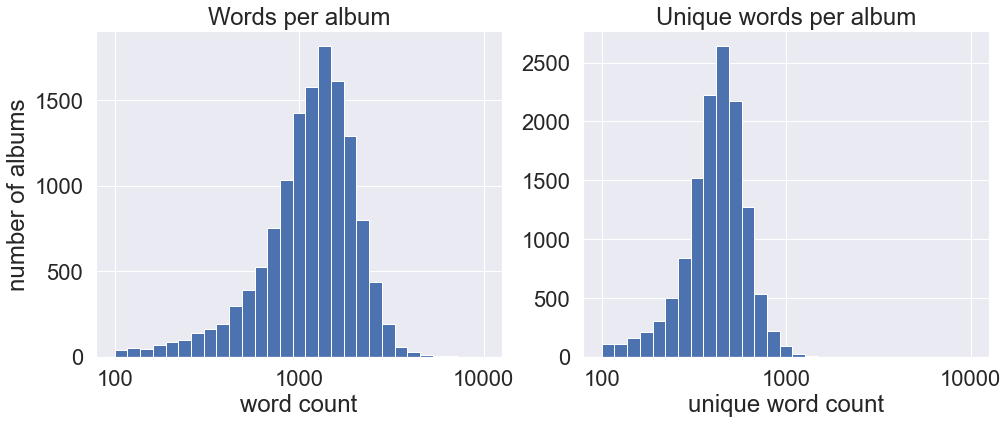

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

df_r_albums['word_count'].hist(bins=np.logspace(2, 4, 30), ax=ax1)
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(ScalarFormatter())
ax1.set_xlabel("word count")
ax1.set_ylabel("number of albums")
ax1.set_title("Words per album")

df_r_albums['unique_word_count'].hist(bins=np.logspace(2, 4, 30), ax=ax2)
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.set_xlabel("unique word count")
ax2.set_title("Unique words per album")

plt.show()

In [13]:
album_cols_show = [c for c in df_r_albums.columns if c != 'words']

#### Albums with highest word counts

In [14]:
df_r_albums.sort_values('word_count', ascending=False).reset_index().shift(1).loc[1:10, album_cols_show].convert_dtypes()

,band,album,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Blind Guardian,Twilight Orchestra: Legacy of the Dark Lands,Speed Metal (early); Power Metal (later),8210,8812,1010,1.07,0.12
2,Bal-Sagoth,The Chthonic Chronicles,Symphonic/Epic Black Metal,3639,6979,2073,1.92,0.57
3,The Gentle Storm,The Diary,Symphonic/Progressive Metal/Rock,6832,6896,810,1.01,0.12
4,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,Symphonic/Epic Black Metal,3157,6500,1634,2.06,0.52
5,Cephalectomy,Sign of Chaos,Experimental Death Metal/Grindcore,2264,6392,958,2.82,0.42
6,Kenn Nardi,Dancing with the Past,Progressive Metal/Rock,9007,6174,1200,0.69,0.13
7,Mayan,Dhyana,Symphonic Death Metal,7394,5618,718,0.76,0.1
8,Vulvodynia,Cognizant Castigation,Deathcore/Brutal Death Metal,4928,5400,854,1.1,0.17
9,Cradle of Filth,"Darkly, Darkly, Venus Aversa",Death Metal (early); Symphonic Black Metal (mi...,4557,5374,1719,1.18,0.38
10,Savatage,The Wake of Magellan,"Heavy/Power Metal, Progressive Metal/Rock",3218,5264,1033,1.64,0.32


#### Albums with highest unique word counts

In [15]:
df_r_albums.sort_values('unique_word_count', ascending=False).reset_index().shift(1).loc[1:10, album_cols_show].convert_dtypes()

,band,album,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Bal-Sagoth,The Chthonic Chronicles,Symphonic/Epic Black Metal,3639,6979,2073,1.92,0.57
2,Cradle of Filth,"Darkly, Darkly, Venus Aversa",Death Metal (early); Symphonic Black Metal (mi...,4557,5374,1719,1.18,0.38
3,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,Symphonic/Epic Black Metal,3157,6500,1634,2.06,0.52
4,Cradle of Filth,Midian,Death Metal (early); Symphonic Black Metal (mi...,3217,3821,1474,1.19,0.46
5,Cradle of Filth,The Manticore and Other Horrors,Death Metal (early); Symphonic Black Metal (mi...,3416,3498,1359,1.02,0.4
6,Lascaille's Shroud,The Roads Leading North,Progressive Death Metal,7720,4800,1359,0.62,0.18
7,Enfold Darkness,Adversary Omnipotent,Technical/Melodic Black/Death Metal,3750,4540,1321,1.21,0.35
8,The Agonist,Prisoners,Melodic Death Metal/Metalcore,3213,3223,1265,1.0,0.39
9,Dying Fetus,Wrong One to Fuck With,Brutal Death Metal/Grindcore,3239,2731,1264,0.84,0.39
10,Cripple Bastards,Desperately Insensitive,Noisecore (early); Grindcore (later),1213,3368,1260,2.78,1.04


#### Albums with highest word density

In [16]:
df_r_albums.sort_values('words_per_second', ascending=False).reset_index().shift(1).loc[1:10, album_cols_show].convert_dtypes()

,band,album,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Cephalectomy,Sign of Chaos,Experimental Death Metal/Grindcore,2264,6392,958,2.82,0.42
2,Cripple Bastards,Desperately Insensitive,Noisecore (early); Grindcore (later),1213,3368,1260,2.78,1.04
3,Cripple Bastards,Misantropo a senso unico,Noisecore (early); Grindcore (later),1459,3710,1069,2.54,0.73
4,Samsas Traum,Heiliges Herz - Das Schwert deiner Sonne,Gothic/Avant-garde Black Metal (early); Neocla...,47,99,59,2.11,1.26
5,Bal-Sagoth,Starfire Burning upon the Ice-Veiled Throne of...,Symphonic/Epic Black Metal,3157,6500,1634,2.06,0.52
6,Fuck the Facts,Mullet Fever,Grindcore,41,84,60,2.05,1.46
7,Melvins,Prick,"Sludge Metal, Various",257,504,193,1.96,0.75
8,Bal-Sagoth,The Chthonic Chronicles,Symphonic/Epic Black Metal,3639,6979,2073,1.92,0.57
9,Municipal Waste,Waste 'Em All,Thrash Metal/Crossover,848,1615,630,1.9,0.74
10,Cripple Bastards,Variante alla morte,Noisecore (early); Grindcore (later),1699,3211,1019,1.89,0.6


#### Albums with highest unique word density

In [17]:
df_r_albums.sort_values('unique_words_per_second', ascending=False).reset_index().shift(1).loc[1:10, album_cols_show].convert_dtypes()

,band,album,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Fuck the Facts,Mullet Fever,Grindcore,41,84,60,2.05,1.46
2,Samsas Traum,Heiliges Herz - Das Schwert deiner Sonne,Gothic/Avant-garde Black Metal (early); Neocla...,47,99,59,2.11,1.26
3,Cripple Bastards,Desperately Insensitive,Noisecore (early); Grindcore (later),1213,3368,1260,2.78,1.04
4,Suicidal Tendencies,Controlled by Hatred / Feel like Shit... Deja Vu,"Thrash Metal/Crossover, Hardcore Punk",196,364,162,1.86,0.83
5,Haggard,Tales of Ithiria,Progressive Death Metal (early); Classical/Orc...,240,299,195,1.25,0.81
6,Gridlink,Orphan,Technical Grindcore,728,1249,565,1.72,0.78
7,Frightmare,Midnight Murder Mania,Death/Thrash Metal/Grindcore,276,349,208,1.26,0.75
8,Melvins,Prick,"Sludge Metal, Various",257,504,193,1.96,0.75
9,Municipal Waste,Waste 'Em All,Thrash Metal/Crossover,848,1615,630,1.9,0.74
10,Gridlink,Amber Gray,Technical Grindcore,710,967,522,1.36,0.74


## Word counts by band

Surprisingly, Bal-Sagoth’s inflated lyric counts do not matter much when comparing entire bands, perhaps due to how short their discography is. The bands with the highest word counts typically have massive discographies, and are usually power metal or heavy metal bands. [Saxon](https://en.wikipedia.org/wiki/Saxon_(band)) rank highest in raw word counts, with nearly over 39,000 words spanning nearly sixteen hours of music, while [Cradle of Filth](https://en.wikipedia.org/wiki/Cradle_of_Filth) throughout their eleven-hour-long discography have used the greatest number of unique words.

In [18]:
df_r_bands = pd.concat([
    df_r_albums.groupby('band')['genre'].first(),
    df_r_albums.groupby('band')['words'].sum(),
    df_r_albums.groupby('band')['seconds'].sum(),
], axis=1)
df_r_bands['word_count'] = df_r_bands['words'].apply(len)
df_r_bands['unique_word_count'] = df_r_bands['words'].apply(lambda x: len(set(x)))
df_r_bands = get_words_per_second(df_r_bands)
df_r_bands = df_r_bands.reset_index()

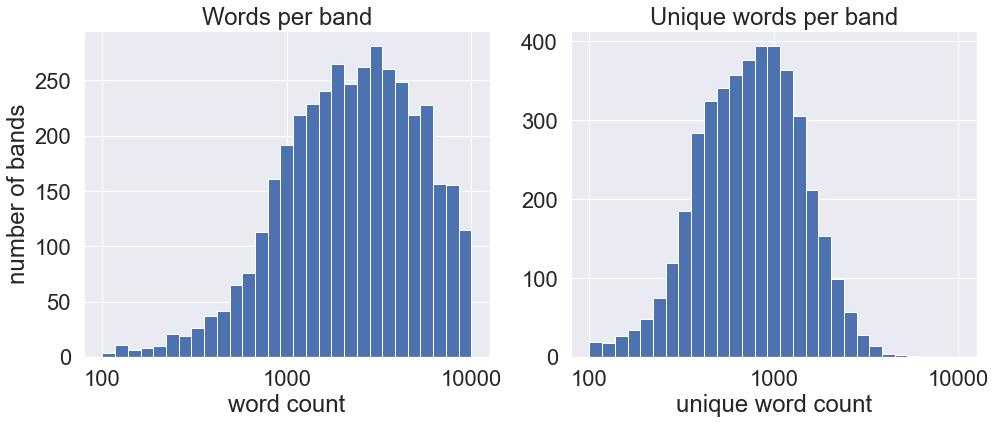

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

df_r_bands['word_count'].hist(bins=np.logspace(2, 4, 30), ax=ax1)
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(ScalarFormatter())
ax1.set_xlabel("word count")
ax1.set_ylabel("number of bands")
ax1.set_title("Words per band")

df_r_bands['unique_word_count'].hist(bins=np.logspace(2, 4, 30), ax=ax2)
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.set_xlabel("unique word count")
ax2.set_title("Unique words per band")

plt.show()

In [20]:
band_cols_show = [c for c in df_r_bands.columns if c != 'words']

#### Bands with highest word counts

In [21]:
df_r_bands.sort_values('word_count', ascending=False).reset_index().shift(1).loc[1:10, band_cols_show].convert_dtypes()

,band,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Saxon,"NWOBHM, Heavy Metal",56651,39019,2732,0.69,0.05
2,Iron Maiden,"Heavy Metal, NWOBHM",58093,38525,3377,0.66,0.06
3,Cradle of Filth,Death Metal (early); Symphonic Black Metal (mi...,39655,37932,6054,0.96,0.15
4,Rage,Heavy/Speed/Power Metal,58844,36476,2959,0.62,0.05
5,Blind Guardian,Speed Metal (early); Power Metal (later),38090,34834,2415,0.91,0.06
6,Overkill,"Thrash Metal, Thrash/Groove Metal",47662,33728,3173,0.71,0.07
7,Cannibal Corpse,Death Metal,34966,32700,4567,0.94,0.13
8,Helloween,Power/Speed Metal,46600,31223,2699,0.67,0.06
9,Judas Priest,Heavy Metal,52478,31097,3551,0.59,0.07
10,Accept,Heavy Metal,40939,29029,2655,0.71,0.06


#### Bands with highest unique word counts

In [22]:
df_r_bands.sort_values('unique_word_count', ascending=False).reset_index().shift(1).loc[1:10, band_cols_show].convert_dtypes()

,band,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Cradle of Filth,Death Metal (early); Symphonic Black Metal (mi...,39655,37932,6054,0.96,0.15
2,Napalm Death,Hardcore Punk (early); Grindcore/Death Metal (...,36761,22260,5081,0.61,0.14
3,Cannibal Corpse,Death Metal,34966,32700,4567,0.94,0.13
4,Skyclad,Folk Metal,25903,26651,4179,1.03,0.16
5,The Black Dahlia Murder,Melodic Death Metal,19546,21928,4132,1.12,0.21
6,Dying Fetus,Brutal Death Metal/Grindcore,16783,15110,3930,0.9,0.23
7,Elephant,Epic Heavy Metal,19168,13893,3865,0.72,0.2
8,Sodom,Black/Speed Metal (early); Thrash Metal (later),35072,26202,3824,0.75,0.11
9,Bal-Sagoth,Symphonic/Epic Black Metal,16021,21458,3730,1.34,0.23
10,Cattle Decapitation,Progressive Death Metal/Grindcore,17320,14363,3624,0.83,0.21


#### Bands with highest word density

In [23]:
df_r_bands.sort_values('words_per_second', ascending=False).reset_index().shift(1).loc[1:10, band_cols_show].convert_dtypes()

,band,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Cephalectomy,Experimental Death Metal/Grindcore,4081,9410,1415,2.31,0.35
2,Cripple Bastards,Noisecore (early); Grindcore (later),8256,16210,3538,1.96,0.43
3,Archagathus,Grindcore (early); Goregrind (later),1149,2113,792,1.84,0.69
4,Gridlink,Technical Grindcore,1438,2216,943,1.54,0.66
5,Crumbsuckers,Thrash Metal/Crossover,1368,2066,516,1.51,0.38
6,Archspire,Technical Death Metal,7084,10633,2344,1.5,0.33
7,Embalmer,Death Metal,266,392,145,1.47,0.55
8,Municipal Waste,Thrash Metal/Crossover,7479,10587,2167,1.42,0.29
9,Varg,Melodic Death/Black Metal/Metalcore,467,645,205,1.38,0.44
10,Blood Freak,Death Metal/Grindcore,4447,6123,1778,1.38,0.4


#### Bands with highest unique word density

In [24]:
df_r_bands.sort_values('unique_words_per_second', ascending=False).reset_index().shift(1).loc[1:10, band_cols_show].convert_dtypes()

,band,genre,seconds,word_count,unique_word_count,words_per_second,unique_words_per_second
1,Archagathus,Grindcore (early); Goregrind (later),1149,2113,792,1.84,0.69
2,Gridlink,Technical Grindcore,1438,2216,943,1.54,0.66
3,Samsas Traum,Gothic/Avant-garde Black Metal (early); Neocla...,307,394,200,1.28,0.65
4,Embalmer,Death Metal,266,392,145,1.47,0.55
5,Acrania,Brutal Deathcore,1674,2282,902,1.36,0.54
6,Revenance,Brutal Death Metal,218,241,115,1.11,0.53
7,Illusion Force,Power Metal,306,386,161,1.26,0.53
8,Hiroshima Will Burn,Technical Deathcore,691,737,360,1.07,0.52
9,The County Medical Examiners,Goregrind,1794,1662,932,0.93,0.52
10,Decrypt,Technical Death Metal/Grindcore,1775,2208,911,1.24,0.51


#### Word counts among the most popular bands

To pick out the most popular bands,
we can filter out artists with fewer than a certain number of reviews.
Plotting out their full-discography unique word counts,
we find that there is a generally linear relationship between the
number of unique words and overall discography length, which is not surprising.
Cradle of Filth sits farthest from the trend line,
with about twice as many words and unique words in their lyrics than expected.
Opeth seems like an outlier on the flip side,
probably due their songs being very heavily instrumental
(Dream Theater probably incorporates more instrumentals but the narrative
nature of their lyrics results in them falling much more in line with heavy/power metal bands).

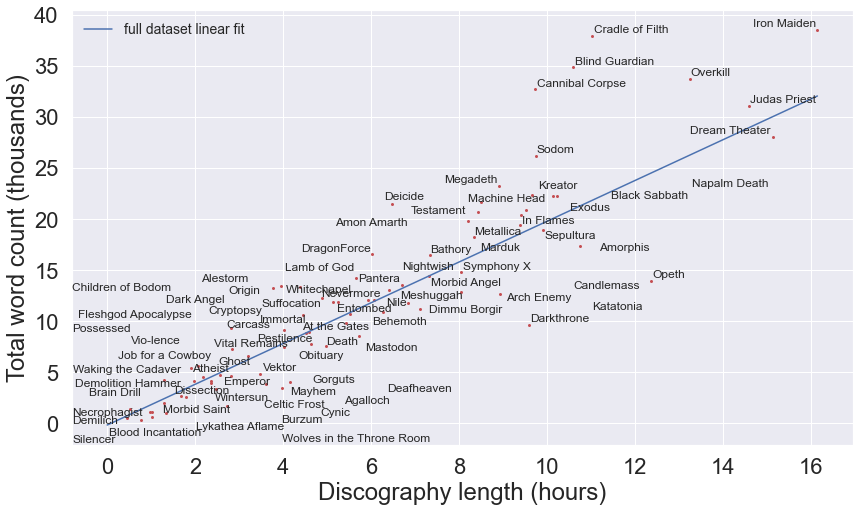

In [25]:
min_reviews = 20

bands_popular = sorted(set(df_r[df_r['album_review_num'] > min_reviews].band_name))
df_r_bands_popular = df_r_bands[df_r_bands.band.isin(bands_popular)].set_index('band', drop=True)

plt.figure(figsize=(14, 8))
xlist, ylist = [], []
for band, row in df_r_bands_popular.iterrows():
    x = row['seconds'] / 3600.0
    y = row['word_count'] / 1000.0
    xlist.append(x)
    ylist.append(y)
    plt.plot(x, y, 'r.')

res = linregress(df_r_bands.seconds / 3600.0, df_r_bands.word_count / 1000.0)
xline = np.linspace(0, df_r_bands_popular.seconds.max() / 3600.0)
yline = xline * res.slope + res.intercept
plt.plot(xline, yline, label='full dataset linear fit')

texts = []
for x, y, band in zip(xlist, ylist, df_r_bands_popular.index):
    texts.append(plt.text(x, y, band, fontsize=12))
adjust_text(texts)

plt.xlabel('Discography length (hours)')
plt.ylabel('Total word count (thousands)')
plt.legend(fontsize=14)
plt.show()

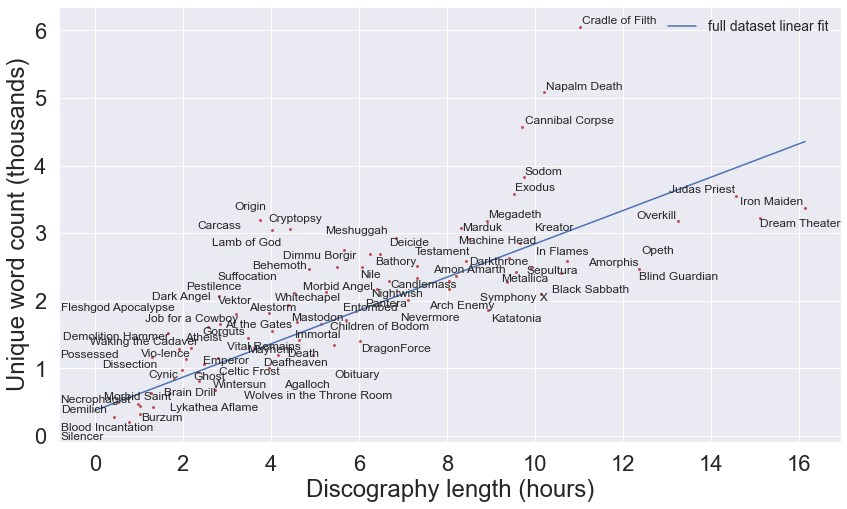

In [26]:
plt.figure(figsize=(14, 8))
xlist, ylist = [], []
for band, row in df_r_bands_popular.iterrows():
    x = row['seconds'] / 3600.0
    y = row['unique_word_count'] / 1000.0
    xlist.append(x)
    ylist.append(y)
    plt.plot(x, y, 'r.')

res = linregress(df_r_bands.seconds / 3600.0, df_r_bands.unique_word_count / 1000.0)
xline = np.linspace(0, df_r_bands_popular.seconds.max() / 3600.0)
yline = xline * res.slope + res.intercept
plt.plot(xline, yline, label='full dataset linear fit')

texts = []
for x, y, band in zip(xlist, ylist, df_r_bands_popular.index):
    texts.append(plt.text(x, y, band, fontsize=12))
adjust_text(texts)

plt.xlabel('Discography length (hours)')
plt.ylabel('Unique word count (thousands)')
plt.legend(fontsize=14)
plt.show()

## Ranking artists by the number of unique words in their first 10,000 words

A few years ago, Matt Daniels of The Pudding wrote up [an article](https://pudding.cool/projects/vocabulary/index.html)
comparing the number of unique words used by several famous rappers in their first 35,000 words.
A similar comparison can be done with the metal lyrics here,
although since heavy metal tends to have more instrumentals and metal musicians don't put out as many songs as rappers do,
I chose to look at each artist's first 10,000 words.
Here, for clarity only the top 100 bands by number of album reviews are shown
but the full plot at the top of the page shows the top 200.
Interestingly, there's a gap between the cluster of highest unique words and the main field of artists.
Every band in the outlier cluster is associated with death metal, hinting at a correlation in genre.
On the dashboard you can filter by genres to see where on the swarm plot those bands lie.

In [27]:
,"""Copied from https://stackoverflow.com/questions/55005272/get-bounding-boxes-of-individual-elements-of-a-pathcollection-from-plt-scatter
"""

from matplotlib.path import get_path_collection_extents

def getbb(sc, ax):
    """ Function to return a list of bounding boxes in data coordinates
        for a scatter plot """
    ax.figure.canvas.draw() # need to draw before the transforms are set.
    transform = sc.get_transform()
    transOffset = sc.get_offset_transform()
    offsets = sc._offsets
    paths = sc.get_paths()
    transforms = sc.get_transforms()

    if not transform.is_affine:
        paths = [transform.transform_path_non_affine(p) for p in paths]
        transform = transform.get_affine()
    if not transOffset.is_affine:
        offsets = transOffset.transform_non_affine(offsets)
        transOffset = transOffset.get_affine()

    if isinstance(offsets, np.ma.MaskedArray):
        offsets = offsets.filled(np.nan)

    bboxes = []

    if len(paths) and len(offsets):
        if len(paths) < len(offsets):
            # for usual scatters you have one path, but several offsets
            paths = [paths[0]]*len(offsets)
        if len(transforms) < len(offsets):
            # often you may have a single scatter size, but several offsets
            transforms = [transforms[0]]*len(offsets)

        for p, o, t in zip(paths, offsets, transforms):
            result = get_path_collection_extents(
                transform.frozen(), [p], [t],
                [o], transOffset.frozen())
            bboxes.append(result.transformed(ax.transData.inverted()))

    return bboxes

In [28]:
def plot_swarm(data, names):
    fig = plt.figure(figsize=(25, 12), facecolor='black')
    ax = sns.swarmplot(x=data, size=50, zorder=1)

    # Get bounding boxes of scatter points
    cs = ax.collections[0]
    boxes = getbb(cs, ax)

    # Add text to circles
    for i, box in enumerate(boxes):
        x = box.x0 + box.width / 2
        y = box.y0 + box.height / 2
        s = names.iloc[i].replace(' ', '\n')
        txt = ax.text(x, y, s, color='white', va='center', ha='center')

        # Shrink font size until text fits completely in circle
        for fs in range(10, 1, -1):
            txt.set_fontsize(fs)
            tbox = txt.get_window_extent().transformed(ax.transData.inverted())
            if (
                    abs(tbox.width) < np.cos(0.5) * abs(box.width)
                    and abs(tbox.height) < np.cos(0.5) * abs(box.height)
            ):
                break

    ax.xaxis.tick_top()
    ax.set_xlabel('')
    ax.tick_params(axis='both', colors='white')

    return fig

In [29]:
band_words = pd.concat(
    (
        df_r.groupby('band_id')['band_name'].first(),
        df_r.groupby(['band_id', 'album_name'])['album_review_num'].first().groupby('band_id').sum(),
        df_r.groupby('band_id')['song_words'].sum()
    ),
    axis=1
)
band_words.columns = ['name', 'reviews', 'words']

In [30]:
band_words.sort_values('reviews')[-200:]

,name,reviews,words
band_id,,,
943,Loudness,47,"[we, are, the, loudness, come, on, now, high, ..."
113185,Fleshgod Apocalypse,47,"[enslaved, with, deceit, by, the, vile, spread..."
106,Edge of Sanity,48,"[smell, the, taste, and, feel, the, sky, contr..."
121,Nuclear Assault,48,"[i, wander, through, the, streets, at, night, ..."
410,The Chasm,48,"[i, look, far, away, the, candles, of, my, bur..."
...,...,...,...
125,Metallica,291,"[no, life, till, leather, we, are, kick, some,..."
97,Judas Priest,318,"[where, would, you, be, without, music, you, w..."
99,Black Sabbath,330,"[what, is, this, that, stands, before, me, fig..."


100


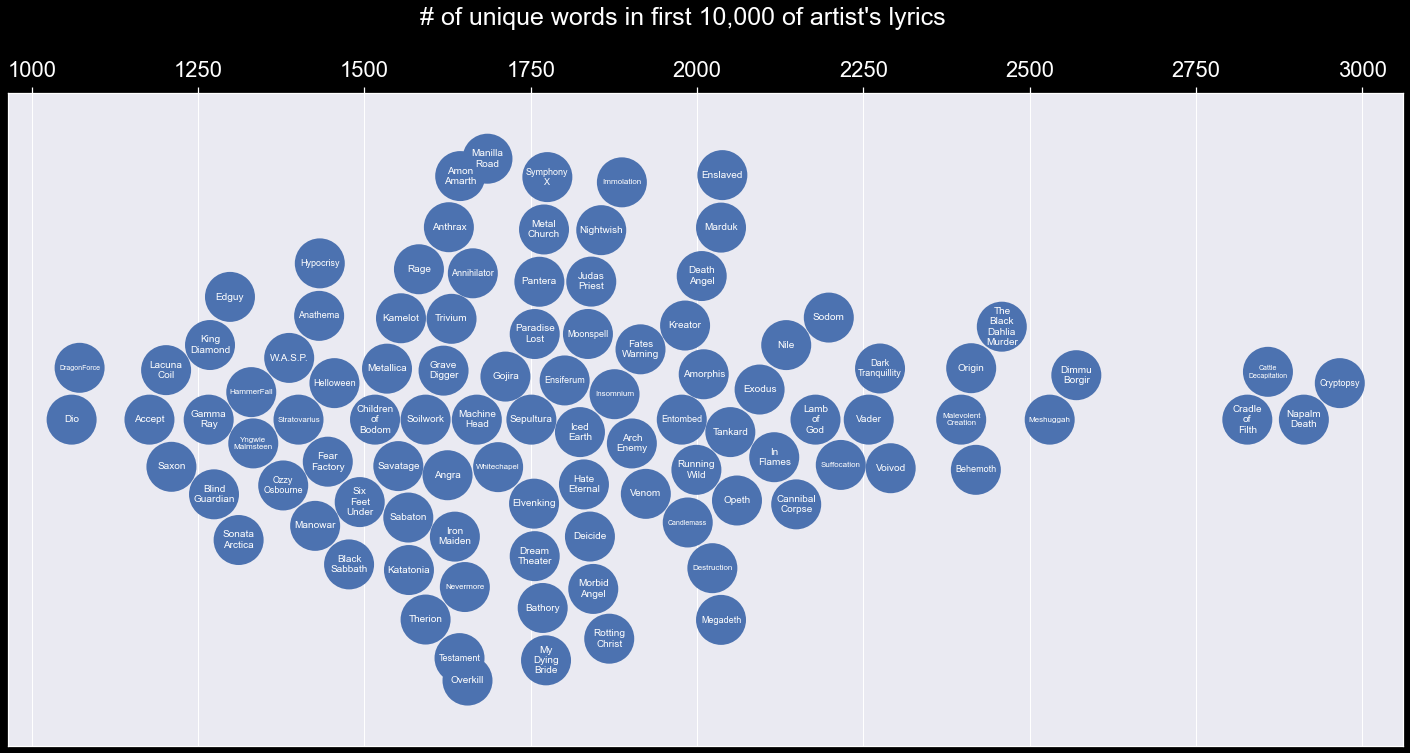

In [31]:
num_bands = 100
num_words = 10000

band_filt_words = band_words[band_words['words'].apply(len) >= num_words].sort_values('reviews')[-num_bands:]
band_filt_words['unique_first_words'] = band_filt_words['words'].apply(lambda x: len(set(x[:num_words])))
band_filt_words = band_filt_words.sort_values('unique_first_words')
print(len(band_filt_words))

fig = plot_swarm(band_filt_words['unique_first_words'], band_filt_words['name'])
fig.suptitle(f"# of unique words in first {num_words:,.0f} of artist's lyrics", color='white', fontsize=25)
plt.show()

100


E:\anaconda3\envs\metallyrics\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


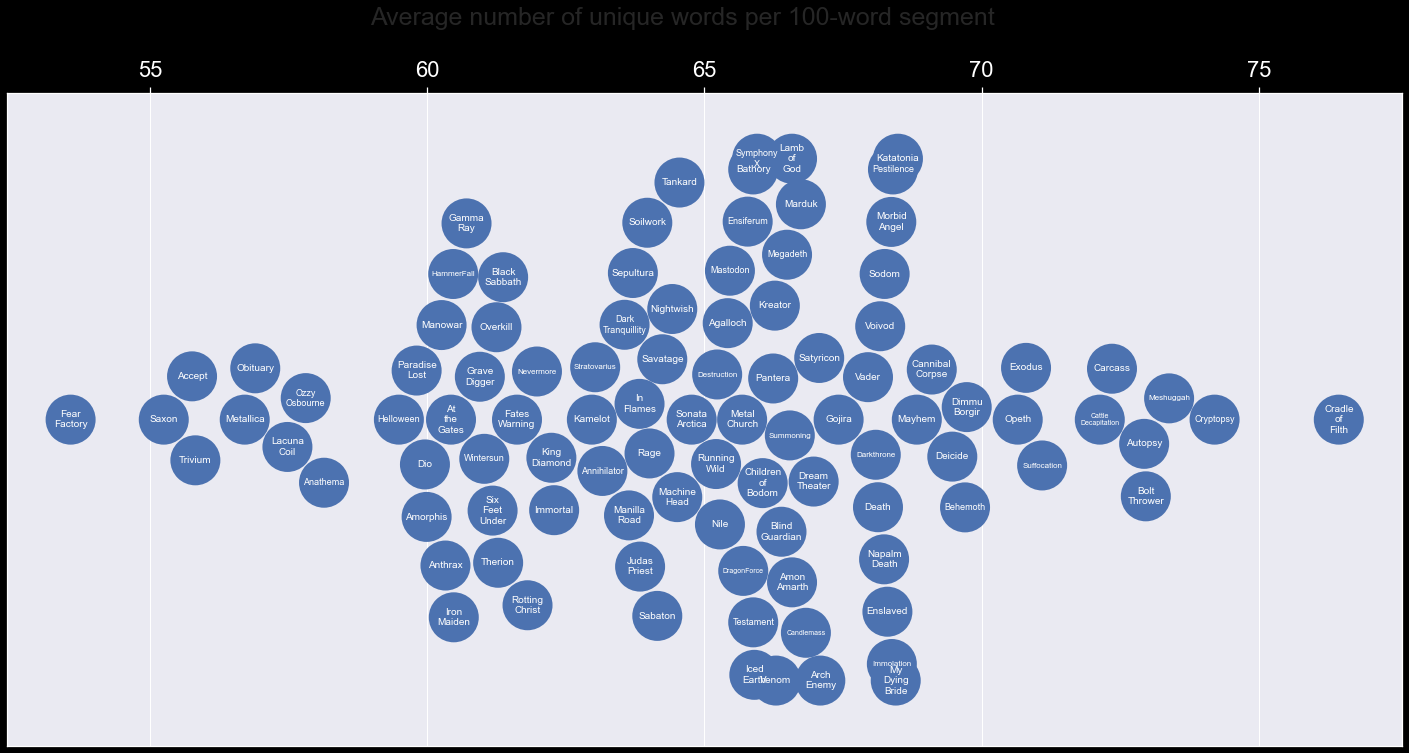

In [32]:
def avg_unique_words(x, n_iter=100, seglen=100):
    counts = np.zeros(n_iter)
    idices = range(len(x) - seglen)
    for i in range(n_iter):
        k = np.random.choice(idices)
        seg = x[k: k + seglen]
        counts[i] = len(set(seg))
    out = counts.mean()
    return out

# min_reviews = 50
# num_words = 1000

# band_filt_words = band_words[(band_words['reviews'] > min_reviews) & (band_words['words'].apply(len) > num_words)].copy()

num_bands = 100
band_filt_words = band_words.loc[band_words.sort_values('reviews')['name'][-num_bands:].index]
print(len(band_filt_words))

band_filt_words['avg_unique_words'] = band_filt_words['words'].apply(avg_unique_words)
band_filt_words = band_filt_words.sort_values('avg_unique_words')

fig = plot_swarm(band_filt_words['avg_unique_words'], band_filt_words['name'])
fig.suptitle('Average number of unique words per 100-word segment', fontsize=25)
plt.show()

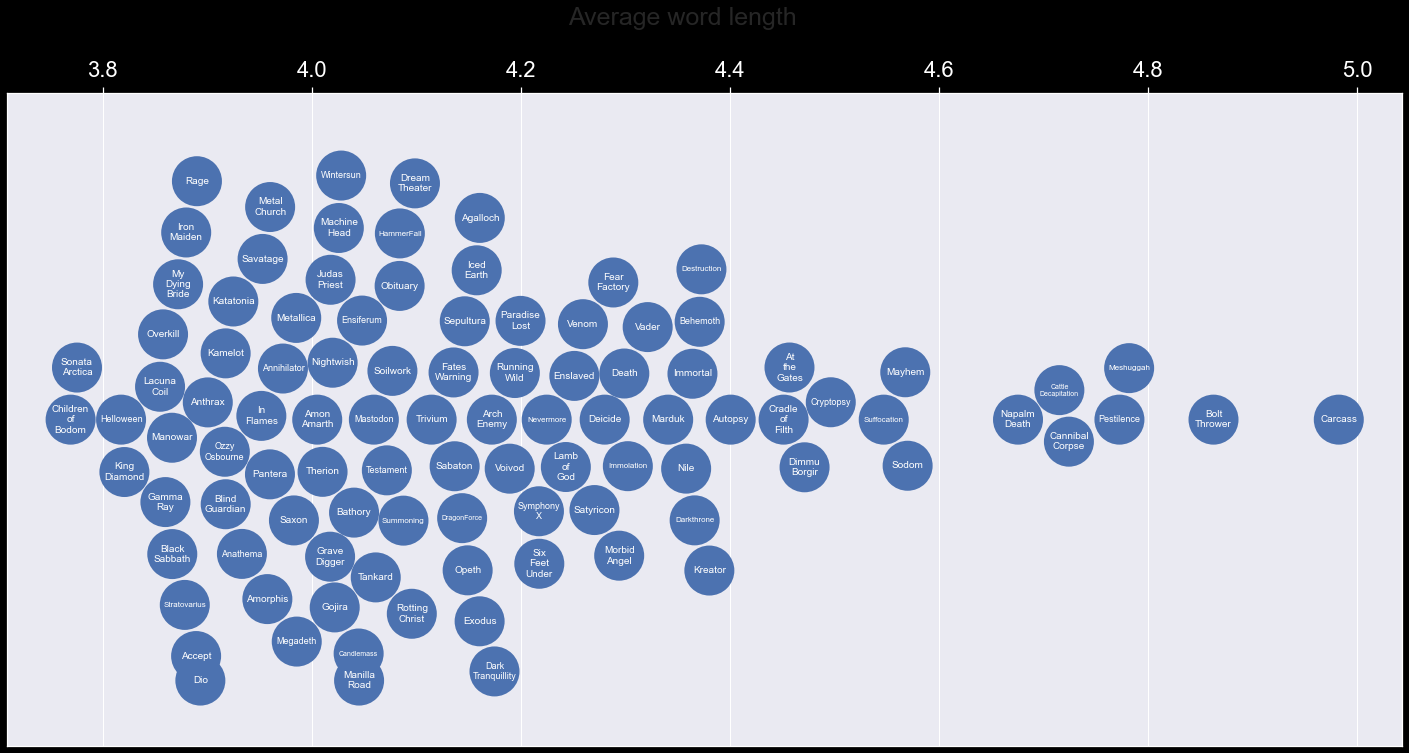

In [33]:
band_filt_words['avg_word_len'] = band_filt_words['words'].apply(lambda x: np.mean(list(map(len, x))))
band_filt_words = band_filt_words.sort_values('avg_word_len')

fig = plot_swarm(band_filt_words['avg_word_len'], band_filt_words['name'])
fig.suptitle('Average word length', fontsize=25)
plt.show()

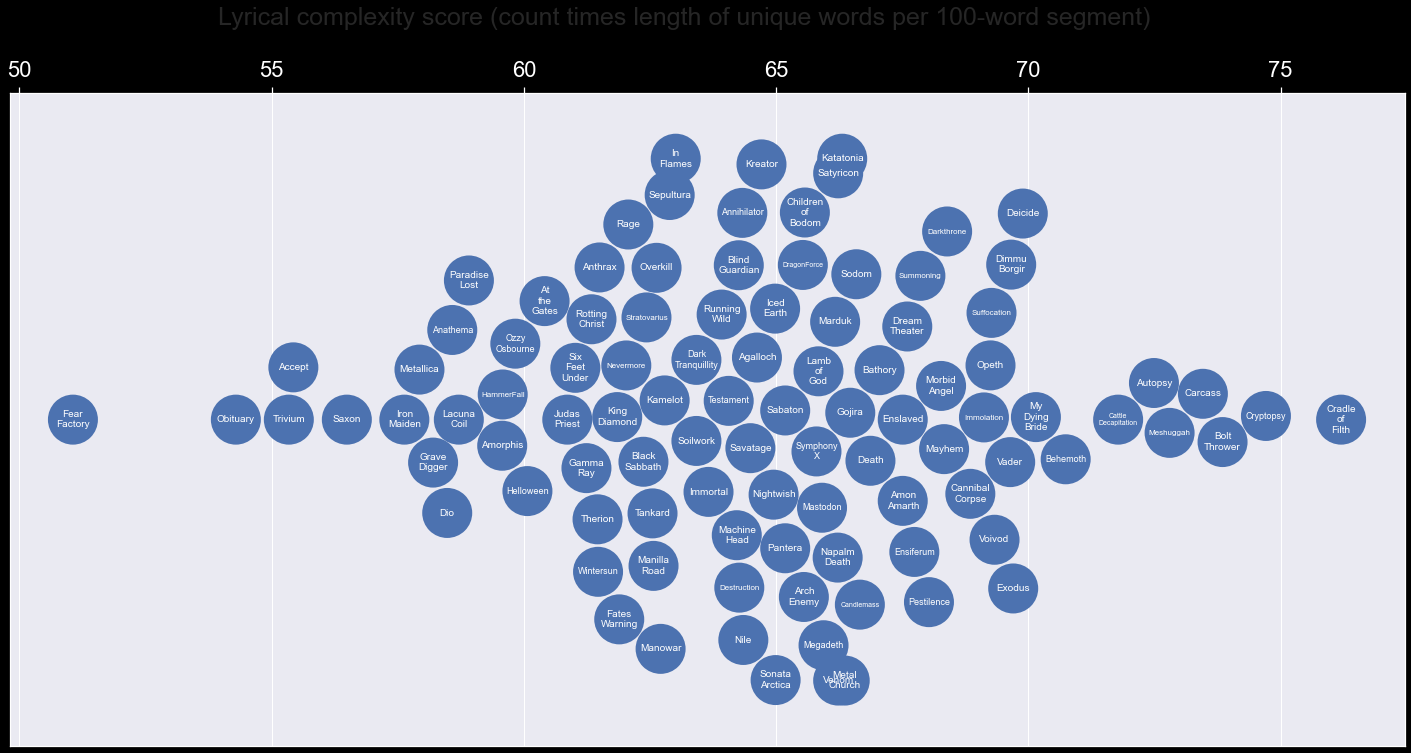

In [34]:
def avg_unique_words_len_weighted(x, n_iter=100, seglen=100):
    counts = np.zeros(n_iter)
    idices = range(len(x) - seglen)
    for i in range(n_iter):
        k = np.random.choice(idices)
        seg = x[k: k + seglen]
        uniq = set(seg)
        avg_len = np.mean(list(map(len, uniq)))
        counts[i] = len(uniq) * avg_len
    out = counts.mean()
    return out

band_filt_words['avg_unique_words_len_weighted'] = band_filt_words['words'].apply(avg_unique_words)
band_filt_words = band_filt_words.sort_values('avg_unique_words_len_weighted')

fig = plot_swarm(band_filt_words['avg_unique_words_len_weighted'], band_filt_words['name'])
fig.suptitle('Lyrical complexity score (count times length of unique words per 100-word segment)', fontsize=25)
plt.show()

# Word counts by genre

Although there are some noticeable trends in the word counts of genres,
overall the distributions of word counts and song lengths per genre are quite broad.
The overlap means lyrical complexity is likely not a sufficient means of distinguishing between genres.
In the next article we'll expand on this, using more sophisticated lexical diversity measures
to quantify the complexity of different genres.

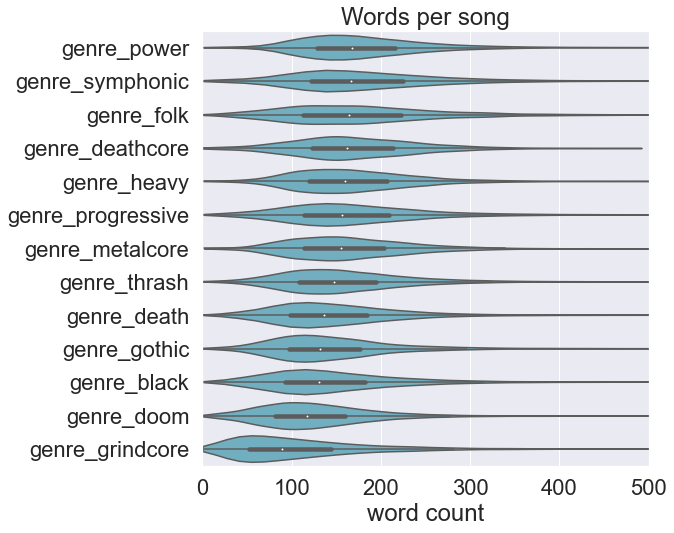

In [35]:
df_genre_songs = df_r[['band_name', 'album_name', 'song_name'] + top_genres_1pct].copy()
df_genre_songs['word_count'] = df_r_songs.word_count
df_genre_songs['seconds'] = df_r_songs.seconds

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
violindata = []
for genre in top_genres_1pct:
    df_genre = df_genre_songs[df_genre_songs[genre] == 1]
    violindata.append((genre, df_genre['word_count']))
violindata.sort(key=lambda x: -np.median(x[1]))
sns.violinplot(data=[x[1] for x in violindata], cut=0, orient='h', color='c')
ax.set_yticklabels([x[0] for x in violindata])
ax.set_xlim(0, 500)
ax.set_title("Words per song")
ax.set_xlabel("word count")
plt.show()

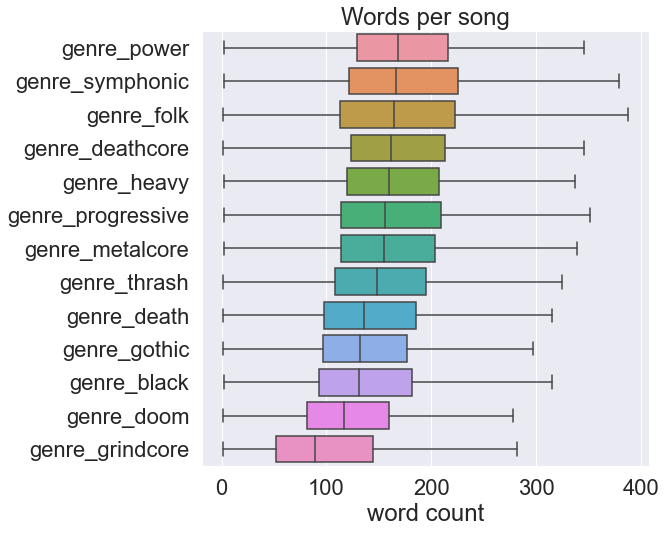

In [36]:
df_genre_songs = df_r[['band_name', 'album_name', 'song_name'] + top_genres_1pct].copy()
df_genre_songs['word_count'] = df_r_songs.word_count
df_genre_songs['seconds'] = df_r_songs.seconds

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
violindata = []
for genre in top_genres_1pct:
    df_genre = df_genre_songs[df_genre_songs[genre] == 1]
    violindata.append((genre, df_genre['word_count'].values))
violindata.sort(key=lambda x: -np.median(x[1]))
sns.boxplot(data=[x[1] for x in violindata], orient='h', showfliers=False)
ax.set_yticklabels([x[0] for x in violindata])
ax.set_xlim
# ax.set_xlim(0, 500)
ax.set_title("Words per song")
ax.set_xlabel("word count")
plt.show()

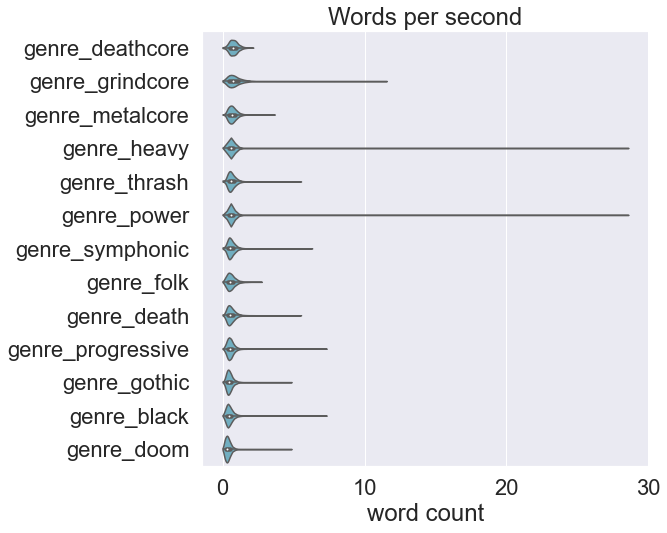

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
violindata = []
for genre in top_genres_1pct:
    df_genre = df_genre_songs[df_genre_songs[genre] == 1].copy()
    df_genre['words_per_second'] = df_genre['word_count'] / df_genre['seconds']
    df_genre.loc[df_genre['words_per_second'] == np.inf, 'words_per_second'] = 0
    violindata.append((genre, df_genre['words_per_second']))
violindata.sort(key=lambda x: -np.median(x[1]))
sns.violinplot(data=[x[1] for x in violindata], cut=0, orient='h', color='c')
ax.set_yticklabels([x[0] for x in violindata])
ax.set_title("Words per second")
ax.set_xlabel("word count")
plt.show()

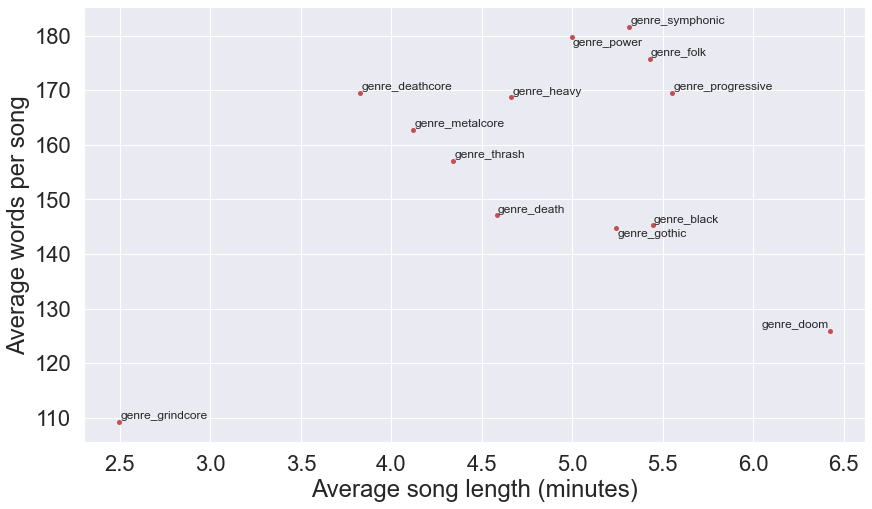

In [38]:
plt.figure(figsize=(14, 8))
xlist, ylist = [], []
for genre in top_genres_1pct:
    df_genre = df_genre_songs[df_genre_songs[genre] == 1].copy()
    x = df_genre['seconds'].mean() / 60.0
    y = df_genre['word_count'].mean()
    xlist.append(x)
    ylist.append(y)
    plt.plot(x, y, 'r.', ms=10, label=genre)
texts = []
for x, y, genre in zip(xlist, ylist, top_genres_1pct):
    texts.append(plt.text(x, y , genre, fontsize=12))
adjust_text(texts)
plt.xlabel('Average song length (minutes)')
plt.ylabel('Average words per song')
plt.show()

### 95% contours for top-five genres

In [39]:
df_genre_10pct_songs = df_rr[['band_name', 'album_name', 'song_name'] + [f"genre_{genre}" for genre in top_genres_10pct]].copy()
df_genre_10pct_songs['song_word_count'] = df_rr.song_words.apply(len)
df_genre_10pct_songs['song_seconds'] = to_seconds(df_rr)

KeyError: "['genre_genre_black', 'genre_genre_death', 'genre_genre_heavy', 'genre_genre_power', 'genre_genre_thrash'] not in index"

In [ ]:
plt.figure(figsize=(14, 8))
ax = plt.gca()
colors = sns.color_palette()
handles = []
for i, genre in enumerate(top_genres_10pct):
    df_genre = df_genre_10pct_songs[df_genre_10pct_songs['genre_' + genre] == 1].copy()
    x = np.log10(df_genre['song_seconds'] / 60.0)
    y = np.log10(df_genre['song_word_count'])
    pos = (x > 0) & (y > 0)
    sns.kdeplot(x=x[pos], y=y[pos], levels=[0.05, 1], ax=ax)
    handles.append(Patch(facecolor=colors[i % len(colors)], label=genre))
ax.set_xticklabels([f"{10**tick:.0f}" for tick in ax.get_xticks()])
ax.set_yticklabels([f"{10**tick:.0f}" for tick in ax.get_yticks()])
ax.set_xlabel('Song length (minutes)')
ax.set_ylabel('Word count per song')
ax.legend(handles=handles)
plt.show()